## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

# Camera Calibration

In [1]:
import numpy as np
import pickle as pickle
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [ ]:
# Read all the chessboard images in for camera calibration
filenames = []
for filename in glob.glob('camera_cal/calibration*'):
    filenames.append(filename)

In [3]:
# Number of Chessboard Corners
nx = 9
ny = 6

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

In [5]:
def camera_calibration(filename, nx=nx, ny=ny):
    '''Camera calibration to draw chessboard corners and append object(3D) and images(2D) points'''
    image = cv2.imread(filename)  # Read filename as image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Image to Grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)  # Corners Found
    if ret == True:  # If corners are found then draw corners
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.figure()
        plt.imshow(image)
    else:
        print("Corners for {} not found".format(filename))

In [ ]:
# Print Chessboard Corners for all filenames
for i in range(len(filenames)):
    camera_calibration(filenames[i])

In [ ]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])  # w x h

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(122)
plt.title("Undistorted Image")
plt.imshow(dst)
plt.show()

In [ ]:
# Saved the value for mtx and dist in a pickle format
pickle.dump( { 'mtx': mtx, 'dist': dist }, open('./camera_cal/pickled_data/camera_calibration.p', 'wb'))

# Distortion Correction to Raw Images

In [8]:
dist_pickle = pickle.load(open('./camera_cal/pickled_data/camera_calibration.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

In [6]:
raw_test_filenames = []
for test_filename in glob.glob('test_images/test*'):
    raw_test_filenames.append(test_filename)

In [ ]:
print(raw_test_filenames)

In [ ]:
test_img = cv2.imread(raw_test_filenames[1])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

test_dst = cv2.undistort(test_img, mtx, dist, None, mtx)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Undistorted Image")
plt.imshow(test_dst)
plt.show()

Looking at the images above undistortion can be clearly be seen more on the edges of the images, i.e. Whole of the white car can be seen in the 'Original Image', whereas some of it has been cut out from 'Undistorted Image'.

# Use Color Transforms, Gradients, etc., to Create a Thresholded Binary Image.

In [9]:
def undistort(image, mtx=mtx, dist=dist):
    '''Undistorted an Image with a given "mtx" and "dist" '''
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

## Applying Sobel

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    ''' 
    Function that applies Sobel x or y, then takes an absolute value
    and applies a threshold.
    '''
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply cv2.Sobel()
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    
    # Scale the result to an 8-but range (0-255)
    scaled_sobel = np.uint8((255 * abs_sobel) / np.max(abs_sobel))
    
    # Create binary_output
    binary_output = np.zeros_like(scaled_sobel)
    
    # Apply lower and upper thresholds
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return value
    return binary_output

In [ ]:
test_binary_image = abs_sobel_thresh(test_dst, orient='x', sobel_kernel=3, thresh=(20, 150))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Threshold")
plt.imshow(test_binary_image, cmap='gray')
plt.show()

## Magnitude of the Gradient

In [11]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    Function that applies Sobel x and y, the computes the magnitude
    of the gradient and applies a threshold
    '''
    # Convert to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separtely
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8 bit (0 - 255) and convert to type np.uint8
    scaled_sobel = np.uint8((255 * mag) / np.max(mag))
    
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return binary_output

In [ ]:
test_mag_image = mag_thresh(test_dst, sobel_kernel=3, mag_thresh=(20, 150))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Magnitude Threshold")
plt.imshow(test_mag_image, cmap='gray')
plt.show()

In [12]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Function that applies Sobel x and y, the computes the direction
    of the gradient and applies a threshold
    '''
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    
    # Calculate the direction of the gradient
    graddir = np.arctan2(absy, absx)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    
    #Return this mask as your binary_output image
    return binary_output

In [ ]:
test_dir_image = dir_thresh(test_dst, sobel_kernel=15, thresh=(0.6, 1.1))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Direction Threshold")
plt.imshow(test_dir_image, cmap='gray')
plt.show()

## Combining Thresholds

In [ ]:
# Choose a Sobel kernel size
ksize = 15 # Larger odd number to smooth gradient measurements
image = test_dst
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 200))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 200))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 150))
dir_binary = dir_thresh(image, sobel_kernel=ksize, thresh=(0.6, 1.1))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Combined Threshold")
plt.imshow(combined, cmap='gray')
plt.show()

## Color Threshold

In [ ]:
hls_image = cv2.cvtColor(test_dst, cv2.COLOR_BGR2HLS)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title("H-channel")
plt.imshow(hls_image[:,:,0], cmap='gray')  # S-channel
plt.subplot(132)
plt.title("L-channel")
plt.imshow(hls_image[:,:,1], cmap='gray')  # S-channel
plt.subplot(133)
plt.title("S-channel")
plt.imshow(hls_image[:,:,2], cmap='gray')  # S-channel
plt.show()

In [13]:
def hls_select(img, thresh=(0, 255)):
    ''' Function that thresholds the S-channel of HLS '''
    
    # HLS Color Space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # Apply threshold to S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])]=1

    # Return a binary image of threshold result
    return binary_output

In [ ]:
test_color_image = hls_select(test_dst, thresh=(90, 255))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Color Threshold")
plt.imshow(test_color_image, cmap='gray')
plt.show()

## Color and Gradient Combined

In [14]:
def color_gradient_thresh(img, ksize=15, s_thresh=(90, 255)):
    ''' Combine Color Threshold and Gradient'''
    # Gradient Thresholds Combined
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 200))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 200))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 150))
    dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.6, 1.1))

    gradient_combined = np.zeros_like(dir_binary)
    gradient_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    
    # HLS Color Space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    color_thresh = np.zeros_like(S)
    color_thresh[(S > s_thresh[0]) & (S <= s_thresh[1])]=1
    
    color_binary = np.dstack(( np.zeros_like(gradient_combined), gradient_combined, color_thresh))
    
    combined_binary = np.zeros_like(gradient_combined)
    combined_binary[(color_thresh == 1)| (gradient_combined == 1)] = 1
    
    return combined_binary

In [ ]:
result = color_gradient_thresh(test_dst)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Combined S-channel and Gradient Threshold")
plt.imshow(result, cmap='gray')
plt.show()

Comparing all the images from before this provides the best lines on the road. There is the are noise in the images on the horizon and above, but that will be removed when masked.

# Apply A Perspective Transform To Rectify Binary Image

In [ ]:
test_img = cv2.imread(raw_test_filenames[1])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(test_img, mtx, dist, None, mtx)
lines_undist = np.copy(undist)

In [ ]:
cv2.line(lines_undist, (230, 720), (570, 480), 255, thickness=3)
cv2.line(lines_undist, (570, 480), (780, 480), 255, thickness=3)
cv2.line(lines_undist, (780, 480), (1180, 720), 255, thickness=3)
plt.figure(figsize=(15, 15))
plt.imshow(lines_undist)

In [16]:
# bottom left, top left, top right, bottom right
src = np.float32([(230, 720), (570, 480), (780, 480), (1180, 720)])
dst = np.float32([(230, 720), (230, 0), (1180, 0), (1180, 720)])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
print("M : {}\n\nMinv : {}".format(M, Minv))

M : [[ -7.48031496e-01  -1.61811024e+00   1.16503937e+03]
 [ -5.27355937e-15  -2.24409449e+00   1.07716535e+03]
 [ -6.93889390e-18  -2.42782152e-03   1.00000000e+00]]

Minv : [[  2.21052632e-01  -7.21052632e-01   5.19157895e+02]
 [ -6.66133815e-16  -4.45614035e-01   4.80000000e+02]
 [ -2.16840434e-18  -1.08187135e-03   1.00000000e+00]]


In [17]:
def warp_perspective(img, M=M, src=np.float32([(230, 720), (570, 480), (780, 480), (1180, 720)]), dst=np.float32([(230, 720), (230, 0), (1180, 0), (1180, 720)])):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

In [ ]:
# bottom left, top left, top right, bottom right
# src = np.float32([(280, 690), (580, 480), (770, 480), (1130, 690)])
# dst = np.float32([(280, 720), (280, 0), (1180, 0), (1180, 720)])
warped = warp_perspective(undist)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Original")
plt.imshow(test_img)
plt.subplot(122)
plt.title("Warped Image")
plt.imshow(warped)
plt.show()

In [ ]:
# Same points to identify curved lanes lines
curved_image = cv2.imread(raw_test_filenames[3])
curved_image = cv2.undistort(curved_image, mtx, dist, None, mtx)
curved_image = cv2.cvtColor(curved_image, cv2.COLOR_BGR2RGB)

# Pipeline (input undistorted image)
test_warp_image = color_gradient_thresh(curved_image)
test_warp_image = warp_perspective(test_warp_image)

# Plotting images
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(curved_image)
plt.subplot(122)
plt.imshow(test_warp_image, cmap='gray')
plt.show()

# Detect Lane Pixels and Fit to Find The Lane Boundary

In [ ]:
# Line Finding Method: Peaks in Histogram

In [ ]:
binary_warped = np.copy(test_warp_image)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2 :, :], axis=0)
plt.plot(histogram)

Two main peaks are shown representing the two lane lines in the image above.

## Implement Sliding Windows and Fit a Polynomial

In [ ]:
# Test image being used is binary_warped as shown in the above cell.
binary_warped = np.copy(test_warp_image)

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lane lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [ ]:
# Choose the number of sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current position to be update for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

#Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [ ]:
# Step throught the windows one by one
for window in range(nwindows):
    # Identify windows boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1) * window_height
    win_y_high = binary_warped.shape[0] - window * window_height
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

In [ ]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right lane pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization

In [ ]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

result = cv2.addWeighted(out_img, 1, out_img, 0.2, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Skip the sliding windows step once you know where the lines are
Now you know where the lines are you have a fit! In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous line position like this:

In [ ]:
# from the next frame of the video (also called "binary_warped")
# It's now much easier to find line pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100

left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Determine the curvature of the lane and vehicle position with respect to center.

In [ ]:
'''
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
'''

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print(left_curverad, right_curverad)

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


## Warp the detected lane boundaries back onto the original image.

In [ ]:
# Create an image to draw the lines on curved_image
warped = np.copy(binary_warped)
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (curved_image.shape[1], curved_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(curved_image, 1, newwarp, 0.3, 0)
plt.imshow(result)

# Pipeline

In [18]:
def find_lanes(img, nwindows=9, margin=100, minpix=50):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:, :], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img  = np.dstack((img, img, img)) * 255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lane lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows    
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current position to be update for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step throught the windows one by one
    for window in range(nwindows):
        # Identify windows boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1) * window_height
        win_y_high = img.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right lane pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (out_img, left_lane_inds, right_lane_inds, left_fit, right_fit, nonzeroy, nonzerox)

In [23]:
def sliding_windows(img, margin=100, left_fit, right_fit):
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return(left_fit, right_fit, nonzeroy, nonzerox)

SyntaxError: non-default argument follows default argument (<ipython-input-23-32174dcfa936>, line 1)

In [24]:
def poly_fit(img, left_fit, right_fit):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return(ploty, left_fitx, right_fitx)

In [26]:
def radius_of_curvature(img, left_fit, right_fit):
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    # Define y-value where we want radius curvature
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return(left_curverad, right_curverad)

In [28]:
def radius_metres(img, ym_per_pix=30/720, xm_per_pix=3.7/700, leftx_base, rightx_base):
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    
    # Define y-value where we want radius curvature
    y_eval = np.max(ploty)
    
    leftx = np.array([leftx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    rightx = np.array([rightx_base + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return(left_curverad, right_curverad)

SyntaxError: non-default argument follows default argument (<ipython-input-28-a7431b0f7280>, line 1)

In [29]:
# bottom left, top left, top right, bottom right
src = np.float32([(230, 720), (570, 480), (780, 480), (1180, 720)])
dst = np.float32([(230, 720), (230, 0), (1180, 0), (1180, 720)])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [30]:
def draw_lane(undist, binary_warped, Minv, left_fitx, right_fitx):
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Create an image to draw the lines on curved_image
    warped = np.copy(binary_warped)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [31]:
# This should be only needed to intialize only once
out_img, left_lane_inds, right_lane_inds, left_fit, right_fit, nonzeroy, nonzerox = find_lanes(binary_warped)
# This will continuously run for the rest of the frame
left_fit, right_fit, nonzeroy, nonzerox = sliding_windows(binary_warped)
result = visualize(binary_warped)

NameError: name 'binary_warped' is not defined

In [32]:
# Camera Calibration
dist_pickle = pickle.load(open('./camera_cal/pickled_data/camera_calibration.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# bottom left, top left, top right, bottom right
src = np.float32([(230, 720), (570, 480), (780, 480), (1180, 720)])
dst = np.float32([(230, 720), (230, 0), (1180, 0), (1180, 720)])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None

Lane = Lane()

def pipeline(img):
    

    # Undistort Original Image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Binary Images - Color and Gradient Threshold
    binary_image = color_gradient_thresh(img, ksize=15, s_thresh=(90, 255))

    # Warp binary_image to get two lane lines perspective from above
    binary_warped = warp_perspective(binary_image)
    
    # Find Lane lines, and get all variables
    out_img, left_lane_inds, right_lane_inds, left_fit, right_fit, nonzeroy, nonzerox = find_lanes(binary_warped)
    
    # Fit polynomial lines for left and right
    ploty, left_fitx, right_fitx = poly_fit(binary_image, left_fit=left_fit, right_fit=right_fit)
    
    # Draw Lane Lines on original image
    result = draw_lane(undist, binary_warped, Minv=Minv, left_fitx=left_fitx, right_fitx=right_fitx)
    
    return result

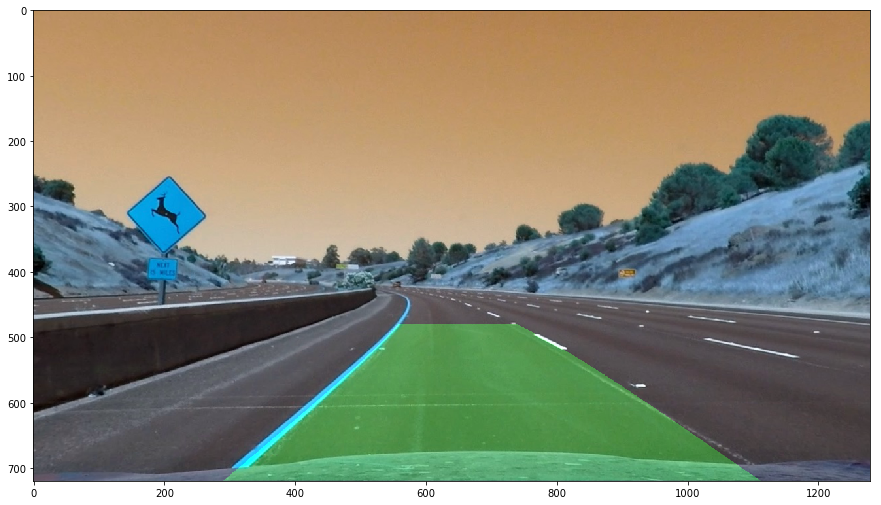

In [33]:
test_img = cv2.imread(raw_test_filenames[3])
result = pipeline(test_img)
plt.figure(figsize=(15,15))
plt.imshow(result)

In [75]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [76]:
video_output = "output_videos/project_video.mp4"
clip = VideoFileClip("./project_video.mp4")
video_clip = clip.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [11:41<00:00,  1.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 16min 4s, sys: 5.22 s, total: 16min 9s
Wall time: 11min 42s


In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))